This notebook contains all experiments and functions to test out Wasserstein nearest neighbors for distributional matrix completion.

In [12]:
from itertools import product
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import matplotlib as mpl
import pylab
import scipy

import warnings
warnings.filterwarnings("ignore")

# NOTE: Whenever lambda functions are used, we create default variables when accessing
# outside variables. This is explained here: https://docs.python.org/3/faq/programming.html#id11

In [13]:
plt.rc('font', family='serif')
plt.rc('text', usetex=False)
plt.rc('axes', axisbelow=True)
label_size = 15
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 
mpl.rcParams['axes.labelsize'] = label_size
mpl.rcParams['axes.titlesize'] = label_size
mpl.rcParams['figure.titlesize'] = label_size
mpl.rcParams['lines.markersize'] = label_size
mpl.rcParams['grid.linewidth'] = 2.5
mpl.rcParams['legend.fontsize'] = label_size
pylab.rcParams['xtick.major.pad']=5
pylab.rcParams['ytick.major.pad']=5

lss = ['--',  ':', '-.', '-', '--', '-.', ':', '-', '--', '-.', ':', '-']
mss = ['>', 'o',  's', 'D', '>', 's', 'o', 'D', '>', 's', 'o', 'D']


### Helper functions

In [14]:
def emp_wasserstein2(u: np.array, v: np.array):
    """
    Returns the squared 2-Wasserstein distance between two
    empirical distributions represented by arrays.
    Assumes the arrays of equal size and are sorted.
    """
    u_sorted = u
    v_sorted = v
    
    return np.sum(np.power(u_sorted - v_sorted,2)) / len(u)
    
def dissim(list1: list[np.array], list2: list[np.array]) -> float:
    """
    Returns a dissimilarity measure between two lists of
    data arrays. Only measures dissimilarity between
    lists that are observed.
    
    If no observations overlap then returns infinity.
    Else returns the average 2-wasserstein distance.
    """
    size = 0
    distance = 0
    for ind in range(len(list1)):
        if len(list1[ind]) == 1 and len(list2[ind]):
            distance += (list1[ind][0] - list2[ind][0]) ** 2
        else:
            # distance += adjusted_emp_wasserstein2(list1[ind], list2[ind]) # unbiased
            distance += emp_wasserstein2(list1[ind],list2[ind]) # biased
        size += 1
    if size == 0:
        return float('inf')
    return distance / size

def get_col(table, col):
    """
    Utility function to get the column of a table
    as a 1-dim list.
    """
    return [table[i][col] for i in range(len(table))]

def barycenter(lists: list[np.array]):
    """
    Returns the barycenter of a list of empirical distributions
    with the same number of samples.
    
    This is just the average of the order statistics of
    each empirical distribution.
    
    Assumes the arrays are of equal length and sorted.
    """
    sorted_data = lists
    
    sum_data = 0
    for l in sorted_data:
        sum_data += l
    
    return sum_data / len(lists)

The 2-Wasserstein metric has a closed-form solution in the 1-dimensional case:

$$W_2(\mu_1,\mu_2) = \left(\int_0^1 \left|F^{-1}_1(q) - F^{-1}_2(q)\right|^2\right)^{1/2}$$

where $F^{-1}_1$ and $F^{-1}_2$ are quantile functions for the distributions.

In [15]:
from scipy.integrate import quad
from scipy.stats import norm
from functools import partial
from numpy import quantile

def wasserstein2(inv_cdf1, inv_cdf2):
    """
    Compute the squared 2-Wasserstein metric.
    """
    # Combine the inner part of the integral into one function
    # Estimate integral via quadrature
    y, _ = quad(lambda x : np.power((inv_cdf1(x) - inv_cdf2(x)), 2), 0, 1)
    return y

def wasserstein2_mc(ppf1, ppf2):
    N = 10000
    u = np.random.uniform(0,1,N)
    return np.sum(np.power(ppf1(u) - ppf2(u), 2)) / N

def empirical_quantile(data_arr):
    """
    Returns a function handle for the empirical quantile
    function given a 1-d dataset.
    """
    return lambda q, data_arr = data_arr : quantile(data_arr, q, method = 'inverted_cdf')

def normal_ppf(mean, std):
    return lambda q, mean = mean, std = std : norm.ppf(q, loc = mean, scale = std)

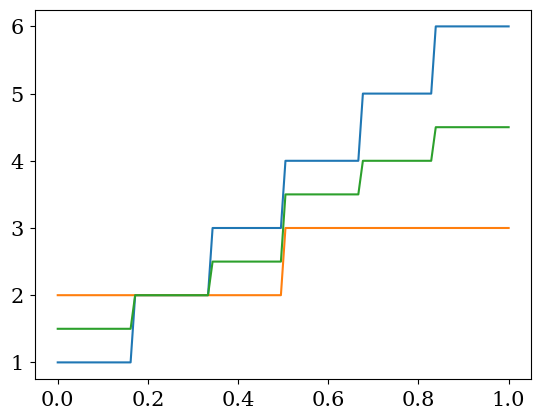

In [16]:
def f1(x):
    return empirical_quantile([1,2,3,4,5,6])(x)

def f2(x):
    return empirical_quantile([2,3])(x)

def f3(x):
    return (f1(x) + f2(x)) / 2

x = np.linspace(0,1,num=100)

plt.figure()
plt.plot(x,f1(x))
plt.plot(x,f2(x))
plt.plot(x,f3(x))
plt.show()

## Visualize Setup

6.642181159250867 16.541648845749712


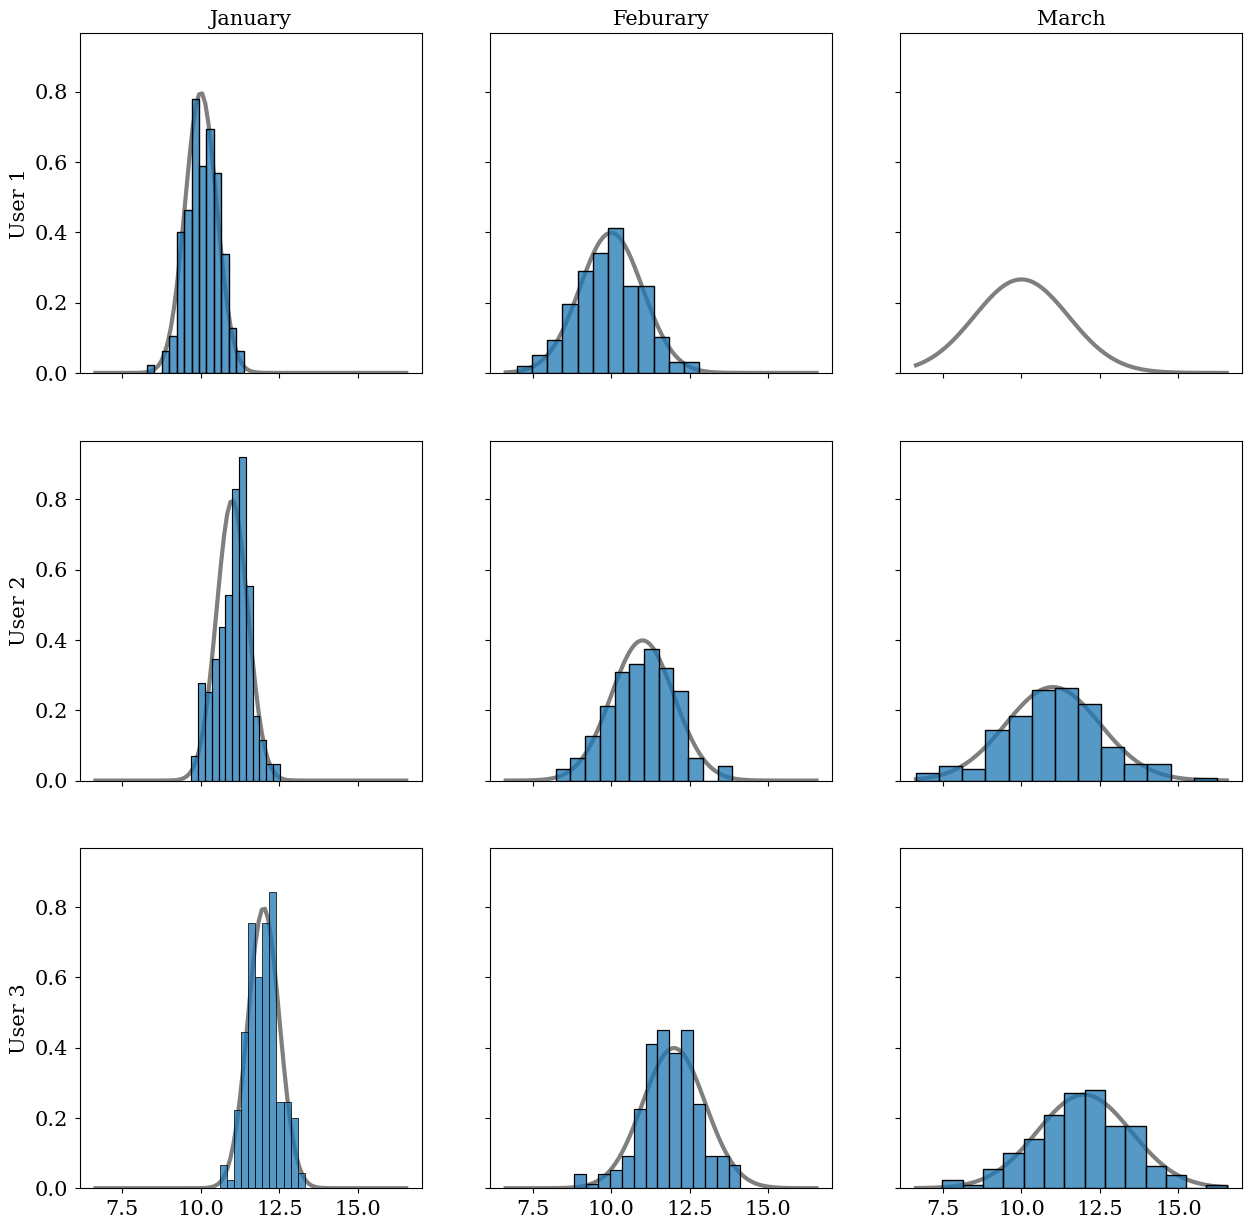

In [243]:
fig, axes = plt.subplots(3, 3, figsize=(15, 15), sharey=True, sharex=True)
min_x = np.inf
max_x = -np.inf
for i in range(3):
    for j in range(3):
        if i == 0 and j == 2:
            continue
        data = np.random.normal(i+10,(j+1) * 0.5,200)
        if min(data) < min_x:
            min_x = min(data)
        if max(data) > max_x:
            max_x = max(data)
        sns.histplot(data, ax=axes[i,j], stat='density', zorder=0)
x = np.linspace(min_x, max_x, 100)
print(min_x, max_x)
for i in range(3):
    for j in range(3):
        pdf = scipy.stats.norm.pdf(x, i+10,(j+1) * 0.5)
        axes[i,j].plot(x, pdf, linewidth=3, alpha=0.5, color='black', zorder=-1)
axes[0,0].set_title("January")
axes[0,1].set_title("Feburary")
axes[0,2].set_title("March")
axes[0,0].set_ylabel("User 1")
axes[1,0].set_ylabel("User 2")
axes[2,0].set_ylabel("User 3")
plt.savefig("figures/setup.pdf")

## Experiments - Rates and Shape

### Helper Functions

In [17]:
def get_user_user_distances_fast(data_table, mask):
    """
    Vectorized version of user-user distances.
    Assumes data_table is a 3D numpy array.
    Assumes mask is a 2D numpy array.
    
    Assumes data is already sorted.
    """
    data_table = np.copy(data_table)
    mask = np.copy(mask)
    
    data_table[mask == 0,:] = np.inf # mask values as infinity for differences
    dists = np.power(data_table[:,None,:,:] - data_table, 2) # each pair of rows differenced
    row_dists = np.mean(dists, axis = 3) # average squared differences across samples
    np.nan_to_num(row_dists, copy = False, nan = 0, posinf=0) # convert nan and inf values to 0
    
    overlap = np.sum(mask[:,None,:] * mask, axis = 2) # get number of overlap elements between each pair of users
    row_dists = np.sum(row_dists, axis = 2) / overlap # average dists across columns
    
    np.fill_diagonal(row_dists, np.inf) # each user is not a nearest neighbor of itself

    return row_dists

def estimate_fast(data_table, mask, row, col, row_dists, eta):
    """
    Vectorized version of nearest neighbors.
    Assumes data_table is a 3D numpy array.
    Assumes mask is a 2D numpy array.
    
    Assumes data is already sorted.
    """
    NN = row_dists < eta # threshold to get nearest neighbors
    NN = NN[row] # get the nearest neighbors for the target user
    if np.sum(NN) > 0:
        return np.mean(data_table[NN, col, :], axis = 0) # barycenter of nearest neighbors
    else:
        data_masked = data_table * mask[:,:,None] # mask the data to exclude data not observed
        return np.mean(data_masked[:, col, :], axis = 0) # barycenter of entire observed column

In [18]:
def get_user_user_distances(data_table, mask, n_rows, n_cols):
    d = {}
    
    for i in range(n_rows):
        for u in range(i,n_rows):
            overlap = {j for j in range(n_cols) if mask[i,j] == 1 and mask[u,j] == 1}
            # if no overlap or looking at the same user
            if i == u or len(overlap) == 0:
                d[i,u] = np.inf
                d[u,i] = np.inf
                continue
            # if overlap, then calcualte dissimilarity
            d[i,u] = dissim([data_table[i,j] for j in range(n) if j in overlap],
                            [data_table[u,j] for j in range(n) if j in overlap])
            d[u,i] = d[i,u]
    return d

def estimate(data_table, mask, row, col, eta, n_rows, n_cols, distances):
    NN = {k for k in range(n_rows) if distances[row, k] <= eta}
    avg_inds = {}
    if len(NN) > 0:
        avg_inds = NN
    else:
        avg_inds = {k for k in range(n_rows) if mask[k,col] == 1}
        
    return barycenter([data_table[k,col] for k in avg_inds])

In [19]:
def get_user_user_distances_row(data_table, mask, row):
    rows, cols, samples = data_table.shape
    dists = np.zeros(rows)
    for i in range(rows):
        if i == row:
            dists[i] = np.inf
            continue
        dist = 0
        count = 0
        for j in range(cols):
            if mask[row,j] == 1 and mask[i,j] == 1:
                dist += emp_wasserstein2(data_table[row,j,:], data_table[i,j,:])
                count += 1
        dists[i] = dist / count
    return dists

def estimate_row(data_table, mask, col, row_dists, eta):
    NN = row_dists < eta # threshold to get nearest neighbors
    
    if np.sum(NN) > 0:
        masked = (NN * mask[:,col]) == 1 # need the ==1 to convert back to booleans
        return np.mean(data_table[masked,col,:], axis = 0)
    else:
        masked = (mask[:,col]) == 1
        return np.mean(data_table[masked, col,:], axis = 0)

In [20]:
from sklearn.model_selection import train_test_split
from copy import deepcopy
from hyperopt import hp, tpe, fmin

def evaluate_eta(data_table, mask, k, eta):
    """
    Run cross validation on the dataset with a given eta.
    """
    n_rows, n_cols,_ = data_table.shape
    observed_inds = np.array([(i,j) for i,j in product(range(n_rows), range(n_cols)) if mask[i,j] == 1])
    np.random.shuffle(observed_inds)
    chunks = np.array_split(observed_inds, k)
    error = 0
    
    for k_ind in range(k):
        test = chunks[k_ind] # left out
        train = np.concatenate([chunks[i] for i in range(k) if i != k_ind]) # everything else
        test_set = {tuple(t) for t in test}
        
        new_mask = np.copy(mask)
        for i,j in product(range(n_rows), range(n_cols)):
            if (i,j) in test_set:
                new_mask[i,j] = 0
        dists = get_user_user_distances_fast(data_table, new_mask)
        
        for i, j in product(range(n_rows), range(n_cols)):
            if (i,j) in test_set:
                est = estimate_fast(data_table, new_mask, i,j, dists, eta)
                error += emp_wasserstein2(est, data_table[i,j])
                
    error /= len(observed_inds)
    return error

def evalute_eta_row(data_table, row, mask, eta):
    """
    Cross validate just on the row we are interested in estimating.
    """
    n_rows, n_cols,_ = data_table.shape
    observed_inds = np.array([j for j in range(n_cols) if mask[row,j] == 1])
    error = 0
    for k in observed_inds:
        new_mask = np.copy(mask)
        new_mask[row,k] = 0
        dists = get_user_user_distances_row(data_table, new_mask, row)
        est = estimate_row(data_table, new_mask, k, dists, eta)
        error += emp_wasserstein2(est, data_table[row,k])
    return error / len(observed_inds)

def search_eta(data_table, mask):
    """
    Search for an optimal eta using cross validation on
    the observed data.
    """
    def obj(eta):
    #     return evaluate_eta(data_table, mask, k, eta)
        return evalute_eta_row(data_table, 0, mask, eta)
    
    best_eta = fmin(fn=obj, verbose = False, space=hp.uniform('eta', 0.0001, 10.0), algo=tpe.suggest, max_evals=30)
    return best_eta['eta']

In [22]:
def simulate_nn_location_scale(M, N, n, n_runs):
    np.random.seed(0)
    error_est = []
    error_observed = []

    for _ in tqdm(range(n_runs), desc=f'{M}, {N}, {n}'):
        # data_table = {}
        true_dists = {}

        # Table of n x m Gaussians with columns having same variance and rows having same means
        mean_rows = np.random.uniform(-5,5,M)
        std_cols = np.random.uniform(0.1,0.5,N)
        
        data_table = np.zeros((M, N, n))

        for i, j in product(range(M), range(N)):
            data = np.sort(np.random.uniform(mean_rows[i], mean_rows[i] + std_cols[j], n))
            data_table[i,j,:] = data
            true_dists[i,j] = lambda q, mean = mean_rows[i], std = std_cols[j] : scipy.stats.uniform.ppf(q, mean, std)
            # data_table[i,j,:] = np.sort(np.random.normal(mean_rows[i], std_cols[j], n))
            # true_dists[i,j] = normal_ppf(mean_rows[i], std_cols[j])

        mask = np.ones((M,N)).astype(int)
        mask[0,0] = 0
        
        eta = search_eta(data_table, mask)

        d = get_user_user_distances_row(data_table, mask, 0)
        est_dist = estimate_row(data_table, mask, 0, d, eta)
        
        error_est.append(wasserstein2(empirical_quantile(est_dist), true_dists[0,0]))
        error_observed.append(wasserstein2(empirical_quantile(data_table[0,0]), true_dists[0,0]))

    return error_est, error_observed

### Experiment 1 - Shape of Distributions

In [44]:
M = 100
N = 20
n = 30

mean_rows = np.random.uniform(-5,5,M)
# std_cols = np.random.uniform(1,5,N)
std_cols = np.ones(N)
data_table = np.zeros((M, N, n))
data_table_dict = {}
true_dists = {}
for i, j in product(range(M), range(N)):
    data = np.sort(np.random.normal(mean_rows[i], std_cols[j], n))
    data_table[i,j,:] = data
    data_table_dict[i,j] = data
    true_dists[i,j] = normal_ppf(mean_rows[i], std_cols[j])
mask = np.ones((M,N)).astype(int)
mask[0,0] = 0

eta = search_eta(data_table, mask)
d = get_user_user_distances_row(data_table, mask, 0)
est_dist = estimate_row(data_table, mask, 0, d, eta)

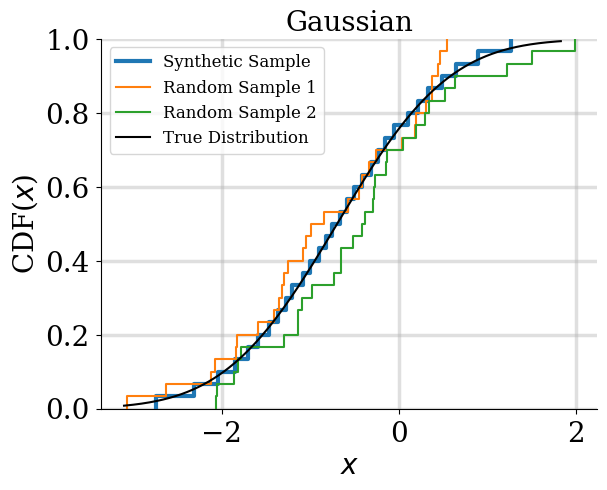

In [45]:
x_min = min(np.min(data_table[0,0]), np.min(est_dist))
x_max = max(np.max(data_table[0,0]), np.max(est_dist))
x = np.linspace(x_min, x_max, num = 1000)
y = scipy.stats.norm.cdf(x, mean_rows[0], std_cols[0])

mpl.rcParams['legend.fontsize'] = 12

# plt.hist(data_table[0,0], density = True, alpha = 0.8)
# plt.hist(est_dist, density = True, alpha = 0.8)
# plt.ecdf(data_table[0,0])
plt.ecdf(est_dist, linewidth=3)
for _ in range(2):
    plt.ecdf(np.random.normal(mean_rows[0], std_cols[0], n))
# sample = np.random.normal(mean_rows[0], std_cols[0], n)
# plt.ecdf(sample)

# est_error = wasserstein2(empirical_quantile(est_dist), true_dists[0,0])
# true_error = wasserstein2(empirical_quantile(sample), true_dists[0,0])

plt.plot(x,y, '-', c='k')
plt.legend(["Synthetic Sample"] + [f"Random Sample {i + 1}" for i in range(2)] + ["True Distribution"])
# plt.legend(["Synthetic Sample", "Random Sample", "True Distribution"])
# plt.title(f"Gaussian Homoscedastic \n Random Sample Error = {true_error:.4f} \n Synthetic Sample Error = {est_error:.4f}")
plt.title("Gaussian")
plt.xlabel("$x$")
plt.ylabel("CDF($x$)")
# plt.ylim([-0.1,1.1])
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(True, alpha=0.4)
plt.savefig(f"figures/denoising-norm-diff-var-cdf-more-random.pdf", bbox_inches="tight")

# print(est_error, true_error)

In [34]:
M = 100
N = 20
n = 30

mean_rows = np.random.uniform(-5,5,M)
std_cols = np.random.uniform(1,5,N)
# std_cols = np.ones(N)
data_table = np.zeros((M, N, n))
true_dists = {}
for i, j in product(range(M), range(N)):
    data = np.sort(np.random.uniform(mean_rows[i], mean_rows[i] + std_cols[j], n))
    data_table[i,j,:] = data
    true_dists[i,j] = lambda q, mean = mean_rows[i], std = std_cols[j] : scipy.stats.uniform.ppf(q, mean, std)
mask = np.ones((M,N)).astype(int)
mask[0,0] = 0

eta = search_eta(data_table, mask)
d = get_user_user_distances_row(data_table, mask, 0)
est_dist = estimate_row(data_table, mask, 0, d, eta)

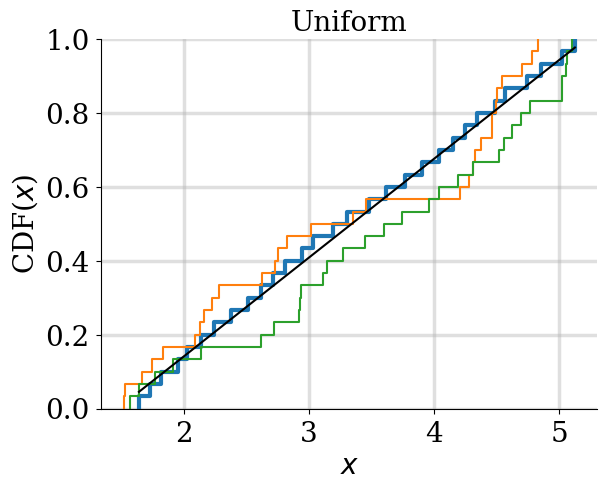

In [37]:
x_min = min(np.min(data_table[0,0]), np.min(est_dist))
x_max = max(np.max(data_table[0,0]), np.max(est_dist))
x = np.linspace(x_min, x_max, num = 1000)
y = scipy.stats.uniform.cdf(x, mean_rows[0], std_cols[0])

plt.ecdf(est_dist, linewidth=3)
for _ in range(2):
    plt.ecdf(np.random.uniform(mean_rows[0], mean_rows[0] + std_cols[0], n))

# est_error = wasserstein2(empirical_quantile(est_dist), true_dists[0,0])
# true_error = wasserstein2(empirical_quantile(sample), true_dists[0,0])

plt.plot(x,y, '-', c='k')
# plt.legend(["Synthetic Sample"] + [f"Random Sample {i + 1}" for i in range(2)] + ["True Distribution"])
# plt.legend(["Synthetic Sample", "Random Sample", "True Distribution"])
# plt.title(f"Gaussian Homoscedastic \n Random Sample Error = {true_error:.4f} \n Synthetic Sample Error = {est_error:.4f}")
# plt.title(f"CDF of DNN Synthetic vs. Random Samples\nUniform Heteroscedastic\n{n} Samples")
plt.title("Uniform")
plt.xlabel("$x$")
plt.ylabel("CDF($x$)")
# plt.ylim([-0.1,1.1])
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(True, alpha=0.4)
plt.savefig(f"figures/denoising-unif-diff-var-cdf-more-random.pdf", bbox_inches="tight")

# print(est_error, true_error)

### Experiment 2 - Error Rates

In [23]:
errors_uniform = {}

In [24]:
# cols = [5, 10, 25, 50, 75]
rows = [5, 10, 25, 50, 100]
# n_runs = 20
# samples = [2, 5, 10, 15, 25, 50, 100, 200, 1000]
n_runs = 50
cols = [10]
# rows = [1000, 5000, 10000]
samples = [2, 5, 10, 50, 100, 500, 1000]

for M, N, n in product(rows, cols, samples):
    errors_uniform[(M, N, n)] = simulate_nn_location_scale(M, N, n, n_runs)

100, 10, 50:  22%|██▏       | 11/50 [00:09<00:35,  1.11it/s]


KeyboardInterrupt: 

In [46]:
import pickle

In [346]:
with open('error_files/errors_row_2.pickle', 'wb') as handle:
    pickle.dump(errors_3, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [360]:
with open('error_files/errors_row_3.pickle', 'wb') as handle:
    pickle.dump(errors_3, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [149]:
with open('error_files/errors_row_3.pickle', 'rb') as f:
    errors = pickle.load(f)

In [150]:
list(errors.keys())

[(10, 10, 2),
 (10, 10, 5),
 (10, 10, 10),
 (10, 10, 50),
 (10, 10, 100),
 (10, 10, 500),
 (10, 10, 1000),
 (25, 10, 2),
 (25, 10, 5),
 (25, 10, 10),
 (25, 10, 50),
 (25, 10, 100),
 (25, 10, 500),
 (25, 10, 1000),
 (50, 10, 2),
 (50, 10, 5),
 (50, 10, 10),
 (50, 10, 50),
 (50, 10, 100),
 (50, 10, 500),
 (50, 10, 1000),
 (100, 10, 2),
 (100, 10, 5),
 (100, 10, 10),
 (100, 10, 50),
 (100, 10, 100),
 (100, 10, 500),
 (100, 10, 1000),
 (500, 10, 2),
 (500, 10, 5),
 (500, 10, 10),
 (500, 10, 50),
 (500, 10, 100),
 (500, 10, 500),
 (500, 10, 1000),
 (1000, 10, 2),
 (1000, 10, 5),
 (1000, 10, 10),
 (1000, 10, 50),
 (1000, 10, 100),
 (1000, 10, 500),
 (1000, 10, 1000),
 (5000, 10, 2),
 (5000, 10, 5),
 (5000, 10, 10),
 (5000, 10, 50),
 (5000, 10, 100),
 (5000, 10, 500),
 (5000, 10, 1000),
 (10000, 10, 2),
 (10000, 10, 5),
 (10000, 10, 10),
 (10000, 10, 50),
 (10000, 10, 100),
 (10000, 10, 500),
 (10000, 10, 1000)]

In [48]:
def fit_power(x,y):
    # y = a * (x ** b)
    # ln(y) = ln(a) + b * ln(x)
    ln_x = np.log(x).reshape(-1,1)
    ln_y = np.log(y).reshape(-1,1)

    X = np.concatenate([np.ones((len(x),1)), 
                        ln_x], 
                       axis=1)
    
    ab = (np.linalg.pinv(X) @ ln_y).flatten()
    
    return np.exp(ab[0]), ab[1]

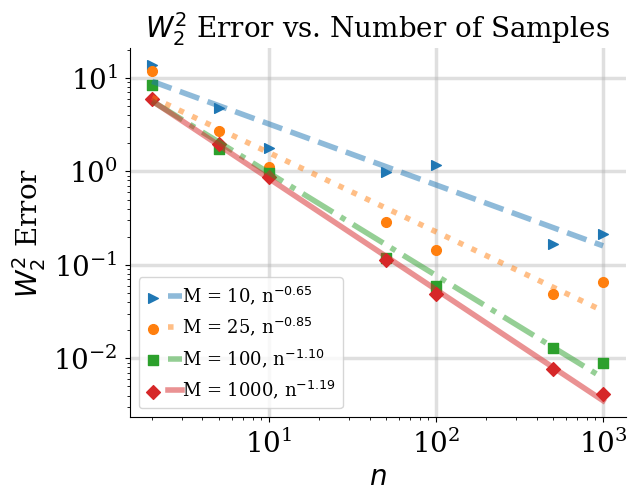

In [180]:
# cols = [5, 10, 25, 50, 75]
# rows = [5, 10, 25, 50, 75]
# samples = [2, 5, 10, 15, 25, 50, 100, 200, 1000]
from matplotlib.legend_handler import HandlerLineCollection, HandlerTuple

cols = [10]
rows = [10, 25, 100, 1000]
samples = [2, 5, 10, 50, 100, 500, 1000]

errors_avg = {k: np.mean(v[0]) for k, v in errors.items()}
errors_std = {k: np.std(v[0]) for k, v in errors.items()}

x = samples
ms = rows
ys = [np.array([errors_avg[m,10,s] for s in x]) for m in ms]

a = []
b = []
for y in ys:
    c,d = fit_power(x, y)
    a.append(c)
    b.append(d)

def f(x,a,b):
    return a * (x ** b)

mpl.rcParams['lines.markersize'] = 7
mpl.rcParams['grid.linewidth'] = 2.5
mpl.rcParams['legend.fontsize'] = 13

plt.figure()
ax = plt.gca()

ax.set_yscale('log')
ax.set_xscale('log')

ls = []
for i, (y,c,d)  in enumerate(zip(ys,a,b)):
    l1 = ax.scatter(x, y, marker=mss[i],alpha=1.0)
    l2, = ax.plot(x,f(x,c,d), lss[i], linewidth=4.0,alpha=0.5)
    ls.append((l1,l2))

labels = [f"M = {m}, " + r"n$^{%.2f}$"%(d) for m,d in zip(ms,b)]

ax.legend(handles = ls, labels = labels, loc='lower left',handletextpad=0.0,
          handler_map = {tuple: HandlerTuple(ndivide=None)})

plt.xlabel("$n$")
plt.ylabel("$W_2^2$ Error")
plt.title("$W_2^2$ Error vs. Number of Samples")
ax.set_ylim(bottom=0)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(True, alpha=0.4)
plt.savefig("figures/error-samples-log-log.pdf", bbox_inches="tight")
plt.show()

# plt.figure()
# plt.plot(ms, b)
# plt.title("Number of Rows vs. Sample Error Rate")
# plt.xlabel("Rows")
# plt.ylabel("Sample Error Rate")
# plt.gca().set_xscale("log")
# # plt.savefig("figures/error-rate-row-samples.pdf")
# plt.show()

In [116]:
error = []
runs = 100
n = 100

for _ in tqdm(range(runs)):
    std = np.random.uniform(1,5)
    ppf = normal_ppf(0, std)
    data = np.random.normal(0,std,n)
    
    error.append(wasserstein2(empirical_quantile(data), ppf))

100%|█████████████████████████████████████████| 100/100 [00:09<00:00, 10.32it/s]


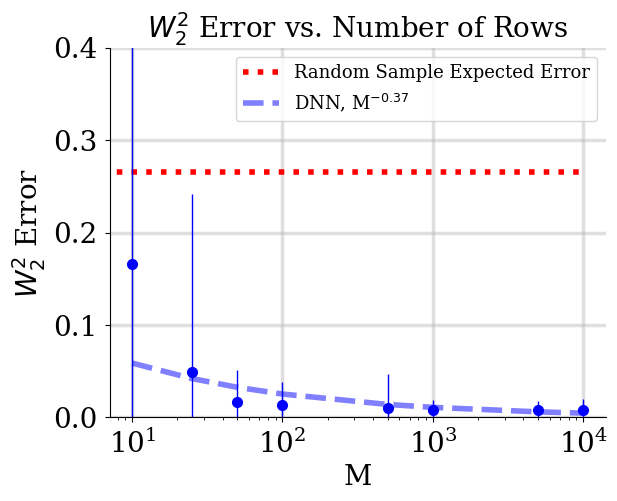

In [174]:
errors_avg = {k: np.mean(v[0]) for k, v in errors.items()}
errors_std = {k: 2 * np.std(v[0]) for k, v in errors.items()}

rows = [10, 25, 50, 100, 500, 1000, 5000, 10000]
s = 500
N = 10
y1 = np.array([errors_avg[m, N, s] for m in rows])
y_err = np.array([errors_std[m, N, s] for m in rows])
# y2 = np.array([errors_avg[m, 10, ss[1]] for m in x])
# y3 = np.array([errors_avg[m, 10, ss[2]] for m in x])

plt.figure()

plt.hlines(np.mean(error), 0, max(rows),colors='r',linestyles='dotted',linewidth=4.0)
plt.errorbar(rows, y1, yerr=y_err, fmt='o', color='b',linewidth=1.0)
# plt.scatter(rows,y1, marker='x', color='b')

def f(x,a,b):
    return a * (x ** b)

a, b = fit_power(rows, y1)
plt.plot(rows, f(rows,a,b), 'b--', alpha=0.5,linewidth=4.0)

ax = plt.gca()
# ax.set_yscale('log')
ax.set_xscale('log')
# ax.set_xscale('log', base=10)

plt.legend([f"Random Sample Expected Error", r"DNN, M$^{%.2f}$"%(b)])
# plt.plot(x, y2, '.-', linewidth=2.0)
# plt.plot(x, y3, '.-', linewidth=2.0)
plt.xlabel("M")
plt.ylabel("$W_2^2$ Error")
plt.title("$W_2^2$ Error vs. Number of Rows")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(True, alpha=0.4)
ax.set_ylim(bottom=0, top = 0.4)
ax.set_xlim(left=0)
# plt.xticks([0] + x)
# plt.xticks(rows)

plt.savefig("figures/error_rows.pdf", bbox_inches="tight")
plt.show()

### Experiment 3 - Variance and Value-at-Risk

In [339]:
M = 100
N = 20
n = 10

np.random.seed(0)

std_dnn_errors = []
var_dnn_errors = []
mean_dnn_errors = []
median_dnn_errors = []

std_errors = []
var_errors = []
mean_errors = []
median_errors = []

# mean_nn_errors = []
std_nn_errors = []

alpha = 0.05

for _ in tqdm(range(30)):
    # data_table = {}
    true_dists = {}

    # Table of n x m Gaussians with columns having same variance and rows having same means
    mean_rows = np.random.uniform(-5,5,M)
    std_cols = np.random.uniform(1,5,N)
    # std_cols = np.ones(N)
    
    data_table = np.zeros((M, N, n))
    data_table_avg = np.zeros((M,N,1))

    for i, j in product(range(M), range(N)):
        data_table[i,j,:] = np.sort(np.random.normal(mean_rows[i], std_cols[j], n))
        true_dists[i,j] = normal_ppf(mean_rows[i], std_cols[j])
        # data_table_avg[i,j,:] = np.mean(data_table[i,j,:], keepdims = True)
        data_table_std[i,j,:] = np.std(data_table[i,j,:], keepdims = True)

    mask = np.ones((M,N)).astype(int)
    mask[0,0] = 0
    
    eta = search_eta(data_table, mask)
    d = get_user_user_distances_row(data_table, mask, 0)
    est = estimate_row(data_table, mask,0, d, eta)

    # eta_nn_avg = estimate_row(data_table_avg, mask,0, d, eta)
    # dists_nn_avg = get_user_user_distances_row(data_table_avg, mask, 0)
    # est_nn_avg = estimate_row(data_table_avg, mask,0, dists_nn_avg, eta_nn_avg)

    eta_nn_std = estimate_row(data_table_std, mask,0, d, eta)
    dists_nn_std = get_user_user_distances_row(data_table_std, mask, 0)
    est_nn_std = estimate_row(data_table_std, mask,0, dists_nn_std, eta_nn_std)

    # var_nn = empirical_quantile(-1 * est)(1 - alpha)
    # var_random = empirical_quantile(-1 * data_table[0,0])(1 - alpha)
    # var_true = normal_ppf(-1 * mean_rows[0], std_cols[0])(1-alpha)
    
    std_dnn_errors.append((np.std(est) - std_cols[0]) ** 2)
    # var_dnn_errors.append((var_nn - var_true) ** 2)
    # mean_dnn_errors.append((np.mean(est) - mean_rows[0]) ** 2)
    # median_dnn_errors.append((np.median(est) - mean_rows[0]) ** 2)

    std_errors.append((np.std(data_table[0,0]) - std_cols[0]) ** 2)
    # var_errors.append((var_random - var_true) ** 2)
    # mean_errors.append((np.mean(data_table[0,0]) - mean_rows[0]) ** 2)
    # median_errors.append((np.median(data_table[0,0]) - mean_rows[0]) ** 2)

    # mean_nn_errors.append((est_nn_avg[0] - mean_rows[0]) ** 2)
    std_nn_errors.append((est_nn_std[0] - std_cols[0]) ** 2)

100%|███████████████████████████████████████████| 30/30 [01:27<00:00,  2.92s/it]


In [63]:
np.mean(std_nn_errors), np.std(std_nn_errors)

(0.022210943732133868, 0.020574289387758855)

In [64]:
np.mean(var_nn_errors), np.std(var_nn_errors)

(0.19681778910574496, 0.6558017947947594)

In [65]:
np.mean(std_errors), np.std(std_errors)

(0.1576184820513153, 0.2692852534469134)

In [66]:
np.mean(var_errors), np.std(var_errors)

(2.070931440524165, 3.8770202280725026)

In [68]:
np.mean(mean_nn_errors), np.std(mean_nn_errors)

(0.06763944060977926, 0.11884379391307616)

In [69]:
np.mean(mean_errors), np.std(mean_errors)

(0.29822359940528403, 0.46216290527641374)

In [327]:
M = 100
N = 20
n = 5

np.random.seed(0)

# dnn_mean_error = []
nn_mean_error = []
# dnn_std_error = []
# nn_std_error = []
# dnn_var_error = []
# nn_var_error = []
# nn_median_error = []

for _ in tqdm(range(30)):
    data_table = np.zeros((M, N, n))
    data_table_avg = np.zeros((M,N,1))
    data_table_std = np.zeros((M,N,1))
    data_table_var = np.zeros((M,N,1))
    data_table_median = np.zeros((M,N,1))
    true_dists = {}

    # Table of m x n Gaussians with columns having same variance and rows having same means
    mean_rows = np.random.uniform(-5,5,M)
    std_cols = np.random.uniform(1,5,N)
    # std_cols = np.ones(N)
    # d = 5
    # row_vectors = np.random.uniform(-2,2,(M,d))
    # col_vectors = np.random.uniform(-2,2,(N,d))
    # std_cols = np.ones((N,1))
    
    for i, j in product(range(M), range(N)):
        # mean = row_vectors[i] @ col_vectors[j]
        # # std = np.abs(row_vectors[i]) @ np.abs(col_vectors[j])
        # std = 1.0
        mean = mean_rows[i]
        std = std_cols[j]
        
        data_unif = np.sort(np.random.uniform(0,1, n))
        ppf = lambda q, loc = mean, scale = std : scipy.stats.norm.ppf(q, loc, scale)
        data = ppf(data_unif)
        data_table[i,j,:] = data
        true_dists[i,j] = ppf
        data_table_avg[i,j,:] = np.mean(data, keepdims = True)
        # data_table_std[i,j,:] = np.std(data, keepdims = True)
        # data_table_var[i,j,:] = empirical_quantile(-1 * data)(1 - alpha)
        # data_table_median[i,j,:] = np.median(data, keepdims=True)

    # true_mean = row_vectors[0] @ col_vectors[0]
    # true_std = np.abs(row_vectors[0]) @ np.abs(col_vectors[0])
    # true_std = 1.0
    true_mean = mean_rows[0]
    true_std = std_cols[0]
    true_var = normal_ppf(-1 * mean_rows[0], std_cols[0])(1-0.05)

    # mask = (np.random.uniform(0,1,(m,n)) < 0.9).astype(int)
    mask = np.ones((M,N)).astype(int)
    mask[0,0] = 0
    
    # eta_dnn = search_eta(data_table, mask)
    eta_nn = search_eta(data_table_avg, mask)
    # eta_nn_std = search_eta(data_table_std, mask)
    # eta_nn_var = search_eta(data_table_var, mask)
    # eta_nn_median = search_eta(data_table_median, mask)

    # dists_dnn = get_user_user_distances_row(data_table, mask, 0)
    dists_nn = get_user_user_distances_row(data_table_avg, mask, 0)
    # dists_nn_std = get_user_user_distances_row(data_table_std, mask, 0)
    # dists_nn_var = get_user_user_distances_row(data_table_var, mask, 0)
    # dists_nn_median = get_user_user_distances_row(data_table_median, mask, 0)

    # est_dnn = estimate_row(data_table, mask,0, dists_dnn, eta_dnn)
    est_nn = estimate_row(data_table_avg, mask,0, dists_nn, eta_nn)
    # est_nn_std = estimate_row(data_table_std, mask,0, dists_nn_std, eta_nn_std)
    # est_nn_var = estimate_row(data_table_var, mask,0, dists_nn_var, eta_nn_var)
    # est_nn_median = estimate_row(data_table_median, mask,0, dists_nn_median, eta_nn_median)
    
    # dnn_error.append(np.mean(est_dnn) - true_mean) ** 2)
    nn_mean_error.append((est_nn - true_mean) ** 2)

    # dnn_std_error.append(np.std(estimate_fast(data_table, mask, 0,0, dists_dnn, eta_dnn) - true_std) ** 2)
    # nn_std_error.append((est_nn_std - true_std) ** 2)
    # nn_var_error.append((est_nn_var - true_var) ** 2)
    # nn_median_error.append((est_nn_median - true_mean) ** 2)

 77%|████████████████████████████████▉          | 23/30 [01:08<00:20,  2.96s/it]


KeyboardInterrupt: 

In [163]:
print(f'DNN: {np.mean(dnn_error):.4f} ± {np.std(dnn_error):.4f}')
print(f'NN: {np.mean(nn_error):.4f} ± {np.std(nn_error):.4f}')

DNN: 2.5358 ± 5.4930
NN: 1.8615 ± 3.4207


In [164]:
print(f'DNN: {np.mean(dnn_std_error):.4f} ± {np.std(dnn_std_error):.4f}')
print(f'NN: {np.mean(nn_std_error):.4f} ± {np.std(nn_std_error):.4f}')

DNN: 0.9496 ± 0.1689
NN: 0.0009 ± 0.0009


In [75]:
print(f'NN: {np.mean(nn_mean_error):.4f} ± {np.std(nn_mean_error):.4f}')
print(f'NN: {np.mean(nn_std_error):.4f} ± {np.std(nn_std_error):.4f}')
print(f'NN: {np.mean(nn_var_error):.4f} ± {np.std(nn_var_error):.4f}')

NN: 0.0579 ± 0.0727
NN: 0.0217 ± 0.0577
NN: 0.2749 ± 0.2960


In [86]:
print(f'NN: {np.median(nn_mean_error):.4f} ± {np.std(nn_mean_error):.4f}')
print(f'NN: {np.median(nn_std_error):.4f} ± {np.std(nn_std_error):.4f}')
print(f'NN: {np.median(nn_var_error):.4f} ± {np.std(nn_var_error):.4f}')

NN: 0.0197 ± 0.0727
NN: 0.0099 ± 0.0577
NN: 0.1729 ± 0.2960


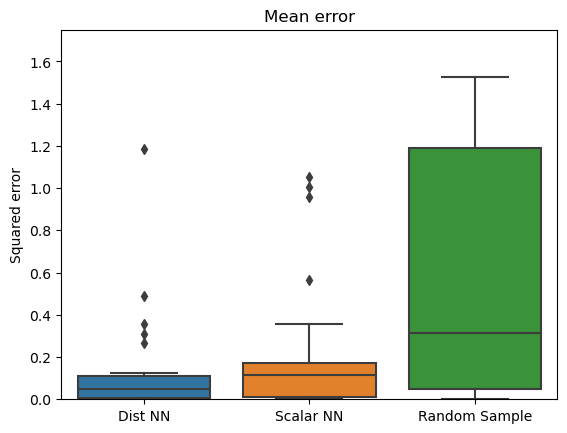

In [332]:
mean_errors_total = np.array([
    mean_dnn_errors,
    mean_nn_errors,
    mean_errors
]).T
labels = ["Dist NN", "Scalar NN", "Random Sample"]
ax = sns.boxplot(mean_errors_total)
plt.ylim([0,1.75])
ax.set_xticklabels(labels)
plt.title("Mean error")
plt.ylabel("Squared error")
plt.savefig("figures/mean.pdf")
# plt.savefig("figures/mean_homo.pdf")
# plt.savefig("figures/mean_hetero.pdf")
plt.show()

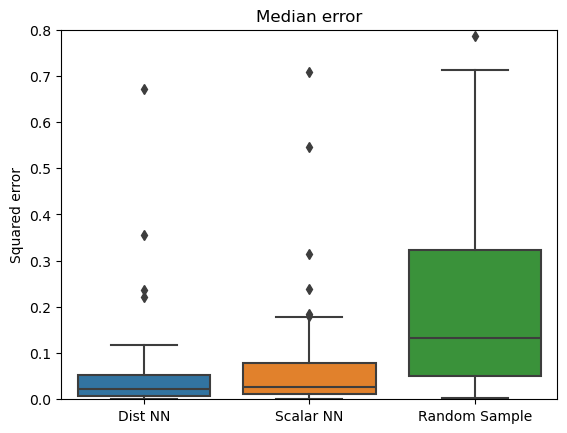

In [293]:
median_errors_total = np.array([
    median_nn_errors,
    np.array(nn_median_error).flatten(),
    median_errors
]).T
labels = ["Dist NN", "Scalar NN", "Random Sample"]
ax = sns.boxplot(median_errors_total)
plt.ylim([0,0.8])
ax.set_xticklabels(labels)
plt.title("Median error")
plt.ylabel("Squared error")
plt.savefig("figures/median.pdf")
plt.show()

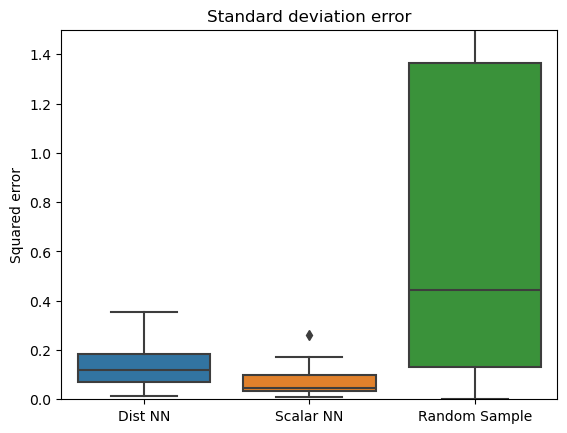

In [343]:
std_errors_total = np.array([
    std_dnn_errors,
    std_nn_errors,
    std_errors
]).T
labels = ["Dist NN", "Scalar NN", "Random Sample"]
ax = sns.boxplot(std_errors_total)
plt.ylim([0,1.5])
ax.set_xticklabels(labels)
plt.title("Standard deviation error")
plt.ylabel("Squared error")
plt.savefig("figures/std.pdf")
plt.show()

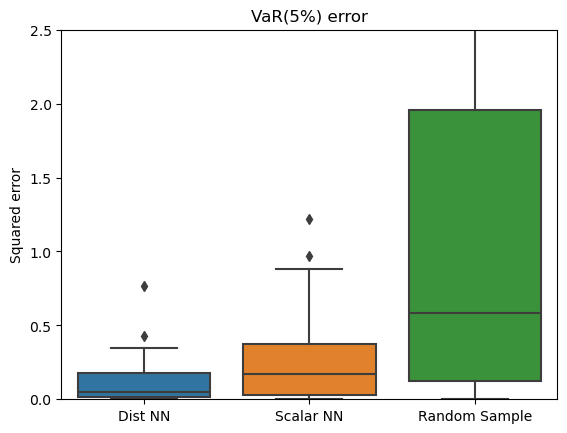

In [132]:
var_errors_total = np.array([
    var_nn_errors,
    np.array(nn_var_error).flatten(),
    var_errors
]).T

labels = ["Dist NN", "Scalar NN", "Random Sample"]
ax = sns.boxplot(var_errors_total)
plt.ylim([0,2.5])
ax.set_xticklabels(labels)
plt.title("VaR(5%) error")
plt.ylabel("Squared error")
plt.savefig("figures/var.pdf")
plt.show()

## Experiment 4 - Uniform Data

In [11]:
def expected_unif_distance(a,b,c,d,n):
    diff1 = b - a
    diff2 = d - c

    return (((diff1 - diff2)**2 )/ 3) + ((a - c)**2) + ((a-c)*(diff1 - diff2)) + ((diff1 * diff2) / (3*(n+1)))

difference = []

a = -2
b = 2
c = 0
d = 1
n = 1000

for _ in tqdm(range(100000)):
    data1 = np.sort(np.random.uniform(a,b,n))
    data2 = np.sort(np.random.uniform(c,d,n))

    difference.append(np.mean(np.power(data1 - data2, 2)))

expected_unif_distance(a,b,c,d,n), np.mean(difference)

100%|██████████| 100000/100000 [00:09<00:00, 10532.46it/s]


(1.0013320013320013, 1.0013753873261013)